In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from tqdm import tqdm
from PIL import Image
import io

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, DenseNet121, InceptionResNetV2, NASNetMobile
from keras.applications.xception import Xception
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import display, clear_output
import ipywidgets as widgets

In [2]:
from google.colab import drive
drive.mount('/content/drive/') 

Mounted at /content/drive/


In [3]:
labels = ['Ulcer', 'Healthy']
X_train = []
Y_train  = []
X_test = []
Y_test = []
image_size=224

for label in labels:
    trainPath = os.path.join('/content/drive/My Drive/DFU Dataset/train',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(label)
    
    testPath = os.path.join('/content/drive/My Drive/DFU Dataset/test',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (image_size, image_size))
        X_test.append(image)
        Y_test.append(label)
    
X_train = np.array(X_train)
X_test = np.array(X_test)

100%|██████████| 110/110 [00:02<00:00, 41.59it/s] 


<ipython-input-4-9c1c85090bd1>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


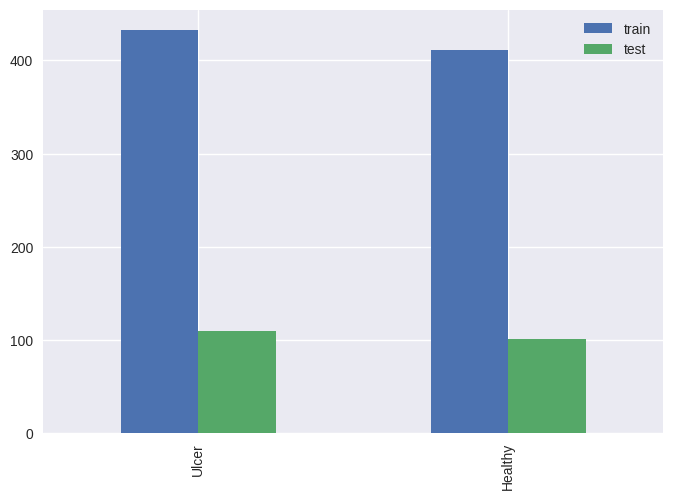

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
_, train_counts = np.unique(Y_train, return_counts=True)
_, test_counts = np.unique(Y_test, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=labels
            ).plot.bar()
plt.savefig('dataset',dpi=400)
plt.show()

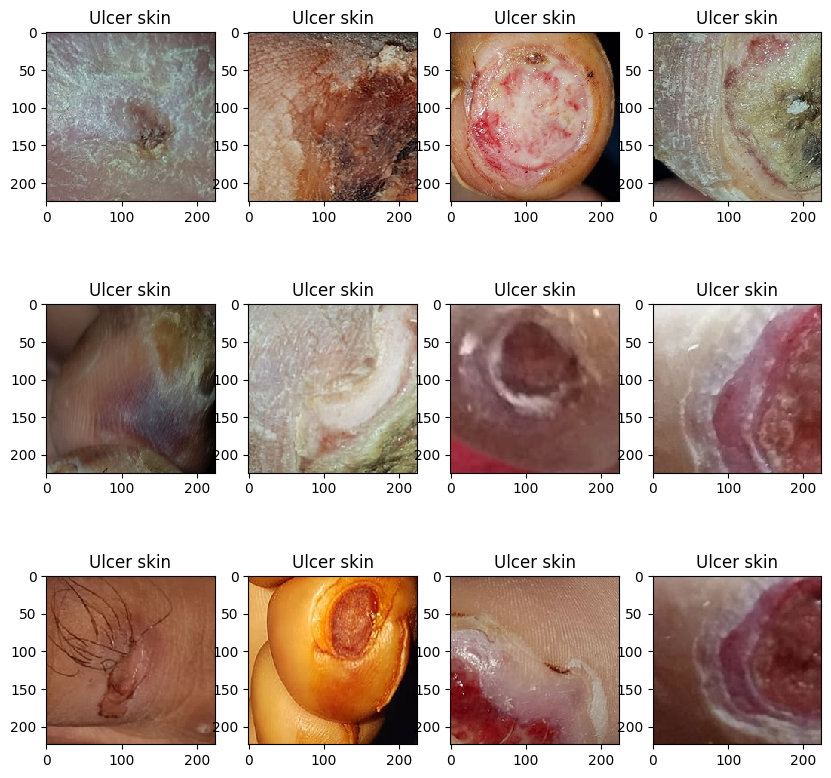

In [5]:
plt.style.use('default')
w=60
h=40
fig=plt.figure(figsize=(10, 10))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Ulcer skin')
    else:
        ax.title.set_text('Healthy skin')
    plt.imshow(X_train[i], interpolation='nearest')
plt.savefig('samples',dpi=400)
plt.show()

In [6]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=1010)
X_train.shape

(844, 224, 224, 3)

In [7]:
X_test, Y_test = shuffle(X_test, Y_test, random_state=1010)
X_test.shape

(211, 224, 224, 3)

In [8]:
y_train_ = []
for i in Y_train:
    y_train_.append(labels.index(i))
Y_train = y_train_

Y_train = tf.keras.utils.to_categorical(Y_train)

y_test_ = []
for i in Y_test:
    y_test_.append(labels.index(i))
Y_test = y_test_

Y_test = tf.keras.utils.to_categorical(Y_test)

In [9]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=1010)

In [10]:
X_train.shape

(759, 224, 224, 3)

In [11]:
X_val.shape

(85, 224, 224, 3)

In [12]:
X_test.shape

(211, 224, 224, 3)

<ipython-input-13-026bd2ea6f27>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


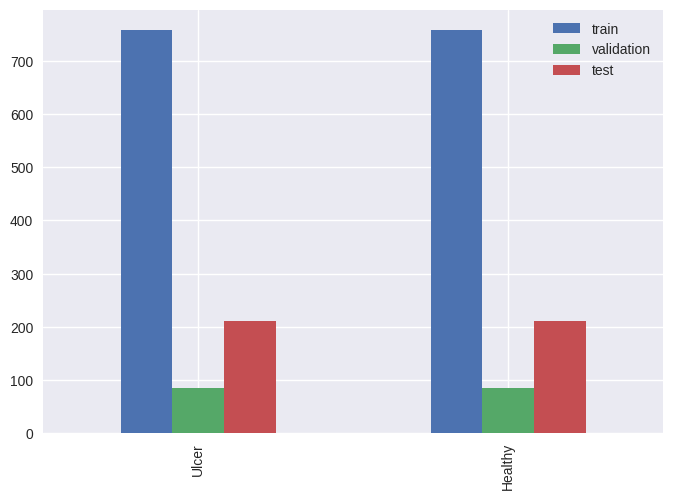

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
_, train_counts = np.unique(Y_train, return_counts=True)
_, val_counts = np.unique(Y_val, return_counts=True)
_, test_counts = np.unique(Y_test, return_counts=True)
pd.DataFrame({'train': train_counts,
                  'validation': val_counts,
                    'test': test_counts}, 
             index=labels
            ).plot.bar()
plt.savefig('dataset1',dpi=400)
plt.show()

In [14]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

87910968/87910968 [==============================] - 4s 0us/step


In [15]:
model = base_model.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.4)(model)
model = BatchNormalization()(model) 
model = Dense(128,activation='relu')(model) 
model = Dropout(0.2)(model)
model = BatchNormalization()(model) 
model = Dense(2, activation='softmax')(model)
model = Model(inputs = base_model.input, outputs=model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [16]:
model.compile(optimizer=Adam(lr=0.0001, decay=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [17]:
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/My Driveweights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [18]:
datagen = ImageDataGenerator(
zoom_range=2,  # set range for random zoom
rotation_range = 90,
shear_range = 0.4,
width_shift_range=0.2,
height_shift_range=0.2,
horizontal_flip=False,
vertical_flip=False)

datagen.fit(X_train)

In [19]:
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=32), steps_per_epoch=X_train.shape[0] / 32,
                              validation_data=(X_val, Y_val), epochs=50, 
                              callbacks=[learn_control, checkpoint])

<ipython-input-19-d2cac84f44e2>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=32), steps_per_epoch=X_train.shape[0] / 32,


Epoch 1/50
24/23 [==============================] - ETA: 0s - loss: 0.5088 - accuracy: 0.7945

23/23 [==============================] - 42s 835ms/step - loss: 0.5088 - accuracy: 0.7945 - val_loss: 0.6885 - val_accuracy: 0.5647 - lr: 1.0000e-04
Epoch 2/50
24/23 [==============================] - ETA: 0s - loss: 0.2486 - accuracy: 0.9223

23/23 [==============================] - 11s 477ms/step - loss: 0.2486 - accuracy: 0.9223 - val_loss: 0.5134 - val_accuracy: 0.7647 - lr: 1.0000e-04
Epoch 3/50
24/23 [==============================] - ETA: 0s - loss: 0.1636 - accuracy: 0.9565

23/23 [==============================] - 12s 490ms/step - loss: 0.1636 - accuracy: 0.9565 - val_loss: 0.6549 - val_accuracy: 0.6471 - lr: 1.0000e-04
Epoch 4/50
24/23 [==============================] - ETA: 0s - loss: 0.1026 - accuracy: 0.9750

23/23 [==============================] - 10s 410ms/step - loss: 0.1026 - accuracy: 0.9750 - val_loss: 0.6010 - val_accuracy: 0.7176 - lr: 1.0000e-04
Epoch 5/50
24/23 [==============================] - ETA: 0s - loss: 0.1296 - accuracy: 0.9513

23/23 [==============================] - 11s 480ms/step - loss: 0.1296 - accuracy: 0.9513 - val_loss: 0.3455 - val_accuracy: 0.8588 - lr: 1.0000e-04
Epoch 6/50
24/23 [==============================] - ETA: 0s - loss: 0.0977 - accuracy: 0.9644

23/23 [==============================] - 11s 474ms/step - loss: 0.0977 - accuracy: 0.9644 - val_loss: 0.4806 - val_accuracy: 0.7882 - lr: 1.0000e-04
Epoch 7/50
24/23 [==============================] - ETA: 0s - loss: 0.1543 - accuracy: 0.9526

23/23 [==============================] - 11s 475ms/step - loss: 0.1543 - accuracy: 0.9526 - val_loss: 0.1075 - val_accuracy: 0.9647 - lr: 1.0000e-04
Epoch 8/50
24/23 [==============================] - ETA: 0s - loss: 0.1073 - accuracy: 0.9631

23/23 [==============================] - 11s 431ms/step - loss: 0.1073 - accuracy: 0.9631 - val_loss: 0.0664 - val_accuracy: 0.9882 - lr: 1.0000e-04
Epoch 9/50
24/23 [==============================] - ETA: 0s - loss: 0.0861 - accuracy: 0.9710

23/23 [==============================] - 11s 481ms/step - loss: 0.0861 - accuracy: 0.9710 - val_loss: 0.1051 - val_accuracy: 0.9529 - lr: 1.0000e-04
Epoch 10/50
24/23 [==============================] - ETA: 0s - loss: 0.0924 - accuracy: 0.9710

23/23 [==============================] - 12s 491ms/step - loss: 0.0924 - accuracy: 0.9710 - val_loss: 0.1413 - val_accuracy: 0.9294 - lr: 1.0000e-04
Epoch 11/50
24/23 [==============================] - ETA: 0s - loss: 0.0793 - accuracy: 0.9750

23/23 [==============================] - 12s 487ms/step - loss: 0.0793 - accuracy: 0.9750 - val_loss: 0.1526 - val_accuracy: 0.9412 - lr: 1.0000e-04
Epoch 12/50
24/23 [==============================] - ETA: 0s - loss: 0.0975 - accuracy: 0.9631

23/23 [==============================] - 12s 468ms/step - loss: 0.0975 - accuracy: 0.9631 - val_loss: 0.1658 - val_accuracy: 0.9294 - lr: 1.0000e-04
Epoch 13/50
24/23 [==============================] - ETA: 0s - loss: 0.0937 - accuracy: 0.9710

23/23 [==============================] - 12s 479ms/step - loss: 0.0937 - accuracy: 0.9710 - val_loss: 0.1932 - val_accuracy: 0.9294 - lr: 1.0000e-04
Epoch 14/50
24/23 [==============================] - ETA: 0s - loss: 0.0633 - accuracy: 0.9789

23/23 [==============================] - 11s 479ms/step - loss: 0.0633 - accuracy: 0.9789 - val_loss: 0.1042 - val_accuracy: 0.9647 - lr: 1.0000e-04
Epoch 15/50
24/23 [==============================] - ETA: 0s - loss: 0.0887 - accuracy: 0.9657

23/23 [==============================] - 12s 480ms/step - loss: 0.0887 - accuracy: 0.9657 - val_loss: 0.0282 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 16/50
24/23 [==============================] - ETA: 0s - loss: 0.0870 - accuracy: 0.9723

23/23 [==============================] - 12s 480ms/step - loss: 0.0870 - accuracy: 0.9723 - val_loss: 0.0342 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 17/50
24/23 [==============================] - ETA: 0s - loss: 0.0842 - accuracy: 0.9750

23/23 [==============================] - 10s 406ms/step - loss: 0.0842 - accuracy: 0.9750 - val_loss: 0.0402 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 18/50
24/23 [==============================] - ETA: 0s - loss: 0.0974 - accuracy: 0.9697

23/23 [==============================] - 11s 461ms/step - loss: 0.0974 - accuracy: 0.9697 - val_loss: 0.0342 - val_accuracy: 0.9882 - lr: 1.0000e-04
Epoch 19/50
24/23 [==============================] - ETA: 0s - loss: 0.0860 - accuracy: 0.9776

23/23 [==============================] - 12s 485ms/step - loss: 0.0860 - accuracy: 0.9776 - val_loss: 0.0449 - val_accuracy: 0.9882 - lr: 1.0000e-04
Epoch 20/50
24/23 [==============================] - ETA: 0s - loss: 0.0738 - accuracy: 0.9736

23/23 [==============================] - 11s 479ms/step - loss: 0.0738 - accuracy: 0.9736 - val_loss: 0.0136 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 21/50
24/23 [==============================] - ETA: 0s - loss: 0.0748 - accuracy: 0.9710

23/23 [==============================] - 12s 488ms/step - loss: 0.0748 - accuracy: 0.9710 - val_loss: 0.0384 - val_accuracy: 0.9765 - lr: 1.0000e-04
Epoch 22/50
24/23 [==============================] - ETA: 0s - loss: 0.0721 - accuracy: 0.9776

23/23 [==============================] - 12s 485ms/step - loss: 0.0721 - accuracy: 0.9776 - val_loss: 0.0282 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 23/50
24/23 [==============================] - ETA: 0s - loss: 0.0788 - accuracy: 0.9710

23/23 [==============================] - 11s 479ms/step - loss: 0.0788 - accuracy: 0.9710 - val_loss: 0.0262 - val_accuracy: 0.9882 - lr: 1.0000e-04
Epoch 24/50
24/23 [==============================] - ETA: 0s - loss: 0.0687 - accuracy: 0.9763

23/23 [==============================] - 12s 484ms/step - loss: 0.0687 - accuracy: 0.9763 - val_loss: 0.0129 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 25/50
24/23 [==============================] - ETA: 0s - loss: 0.0445 - accuracy: 0.9881

23/23 [==============================] - 11s 472ms/step - loss: 0.0445 - accuracy: 0.9881 - val_loss: 0.0506 - val_accuracy: 0.9765 - lr: 1.0000e-04
Epoch 26/50
24/23 [==============================] - ETA: 0s - loss: 0.0877 - accuracy: 0.9697

23/23 [==============================] - 10s 422ms/step - loss: 0.0877 - accuracy: 0.9697 - val_loss: 0.0067 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 27/50
24/23 [==============================] - ETA: 0s - loss: 0.0603 - accuracy: 0.9802

23/23 [==============================] - 12s 477ms/step - loss: 0.0603 - accuracy: 0.9802 - val_loss: 0.0389 - val_accuracy: 0.9765 - lr: 1.0000e-04
Epoch 28/50
24/23 [==============================] - ETA: 0s - loss: 0.0558 - accuracy: 0.9776

23/23 [==============================] - 12s 487ms/step - loss: 0.0558 - accuracy: 0.9776 - val_loss: 0.0589 - val_accuracy: 0.9765 - lr: 1.0000e-04
Epoch 29/50
24/23 [==============================] - ETA: 0s - loss: 0.0817 - accuracy: 0.9723

23/23 [==============================] - 12s 485ms/step - loss: 0.0817 - accuracy: 0.9723 - val_loss: 0.0883 - val_accuracy: 0.9647 - lr: 1.0000e-04
Epoch 30/50
24/23 [==============================] - ETA: 0s - loss: 0.0633 - accuracy: 0.9789

23/23 [==============================] - 12s 490ms/step - loss: 0.0633 - accuracy: 0.9789 - val_loss: 0.1110 - val_accuracy: 0.9765 - lr: 1.0000e-04
Epoch 31/50
24/23 [==============================] - ETA: 0s - loss: 0.0490 - accuracy: 0.9816

23/23 [==============================] - 10s 429ms/step - loss: 0.0490 - accuracy: 0.9816 - val_loss: 0.0526 - val_accuracy: 0.9765 - lr: 1.0000e-04
Epoch 32/50
24/23 [==============================] - ETA: 0s - loss: 0.0504 - accuracy: 0.9829

23/23 [==============================] - 11s 445ms/step - loss: 0.0504 - accuracy: 0.9829 - val_loss: 0.1245 - val_accuracy: 0.9529 - lr: 1.0000e-04
Epoch 33/50
24/23 [==============================] - ETA: 0s - loss: 0.0700 - accuracy: 0.9763

23/23 [==============================] - 12s 482ms/step - loss: 0.0700 - accuracy: 0.9763 - val_loss: 0.0306 - val_accuracy: 0.9765 - lr: 1.0000e-04
Epoch 34/50
24/23 [==============================] - ETA: 0s - loss: 0.0547 - accuracy: 0.9842

23/23 [==============================] - 11s 478ms/step - loss: 0.0547 - accuracy: 0.9842 - val_loss: 0.0188 - val_accuracy: 0.9882 - lr: 1.0000e-04
Epoch 35/50
24/23 [==============================] - ETA: 0s - loss: 0.0645 - accuracy: 0.9829

23/23 [==============================] - 11s 441ms/step - loss: 0.0645 - accuracy: 0.9829 - val_loss: 0.0145 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 36/50
24/23 [==============================] - ETA: 0s - loss: 0.0578 - accuracy: 0.9789

23/23 [==============================] - 11s 438ms/step - loss: 0.0578 - accuracy: 0.9789 - val_loss: 0.0057 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 37/50
24/23 [==============================] - ETA: 0s - loss: 0.0550 - accuracy: 0.9802

23/23 [==============================] - 11s 479ms/step - loss: 0.0550 - accuracy: 0.9802 - val_loss: 0.0263 - val_accuracy: 0.9882 - lr: 1.0000e-04
Epoch 38/50
24/23 [==============================] - ETA: 0s - loss: 0.0506 - accuracy: 0.9842

23/23 [==============================] - 12s 489ms/step - loss: 0.0506 - accuracy: 0.9842 - val_loss: 0.0211 - val_accuracy: 0.9882 - lr: 1.0000e-04
Epoch 39/50
24/23 [==============================] - ETA: 0s - loss: 0.0545 - accuracy: 0.9829

23/23 [==============================] - 11s 475ms/step - loss: 0.0545 - accuracy: 0.9829 - val_loss: 0.1328 - val_accuracy: 0.9529 - lr: 1.0000e-04
Epoch 40/50
24/23 [==============================] - ETA: 0s - loss: 0.0647 - accuracy: 0.9776

23/23 [==============================] - 10s 438ms/step - loss: 0.0647 - accuracy: 0.9776 - val_loss: 0.1289 - val_accuracy: 0.9529 - lr: 1.0000e-04
Epoch 41/50
24/23 [==============================] - ETA: 0s - loss: 0.0560 - accuracy: 0.9776

23/23 [==============================] - 11s 440ms/step - loss: 0.0560 - accuracy: 0.9776 - val_loss: 0.0053 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 42/50
24/23 [==============================] - ETA: 0s - loss: 0.0597 - accuracy: 0.9842

23/23 [==============================] - 11s 476ms/step - loss: 0.0597 - accuracy: 0.9842 - val_loss: 0.0030 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 43/50
24/23 [==============================] - ETA: 0s - loss: 0.0523 - accuracy: 0.9829

23/23 [==============================] - 12s 481ms/step - loss: 0.0523 - accuracy: 0.9829 - val_loss: 0.0043 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 44/50
24/23 [==============================] - ETA: 0s - loss: 0.0584 - accuracy: 0.9802

23/23 [==============================] - 10s 436ms/step - loss: 0.0584 - accuracy: 0.9802 - val_loss: 0.0064 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 45/50
24/23 [==============================] - ETA: 0s - loss: 0.0800 - accuracy: 0.9776

23/23 [==============================] - 11s 446ms/step - loss: 0.0800 - accuracy: 0.9776 - val_loss: 0.0090 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 46/50
24/23 [==============================] - ETA: 0s - loss: 0.0671 - accuracy: 0.9802

23/23 [==============================] - 11s 475ms/step - loss: 0.0671 - accuracy: 0.9802 - val_loss: 0.0078 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 47/50
24/23 [==============================] - ETA: 0s - loss: 0.0536 - accuracy: 0.9829

23/23 [==============================] - 11s 476ms/step - loss: 0.0536 - accuracy: 0.9829 - val_loss: 0.0063 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 48/50
24/23 [==============================] - ETA: 0s - loss: 0.0609 - accuracy: 0.9842

23/23 [==============================] - 12s 487ms/step - loss: 0.0609 - accuracy: 0.9842 - val_loss: 0.0022 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 49/50
24/23 [==============================] - ETA: 0s - loss: 0.0627 - accuracy: 0.9842

23/23 [==============================] - 10s 422ms/step - loss: 0.0627 - accuracy: 0.9842 - val_loss: 0.0050 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 50/50
24/23 [==============================] - ETA: 0s - loss: 0.0356 - accuracy: 0.9908

23/23 [==============================] - 11s 444ms/step - loss: 0.0356 - accuracy: 0.9908 - val_loss: 0.0072 - val_accuracy: 1.0000 - lr: 1.0000e-04


<ipython-input-20-1daa862870d7>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


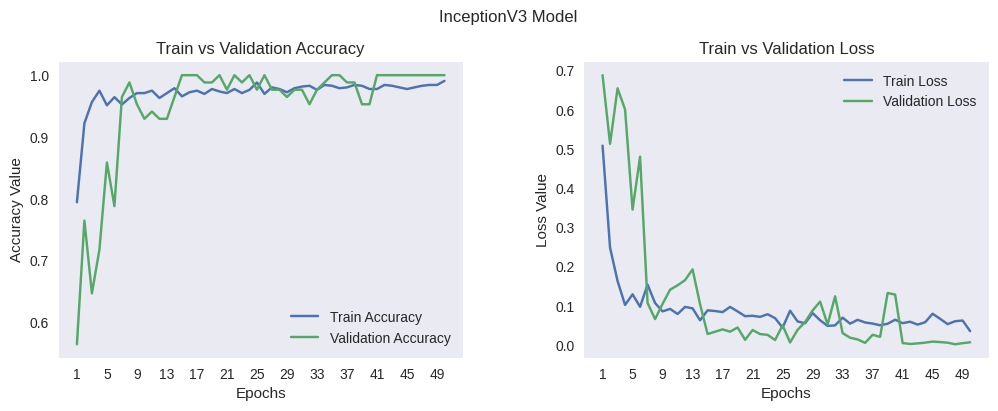

In [20]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('InceptionV3 Model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,51))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 51, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epochs')
ax1.set_title('Train vs Validation Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 51, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epochs')
ax2.set_title('Train vs Validation Loss')
l2 = ax2.legend(loc="best")
plt.savefig('curve',dpi=400)

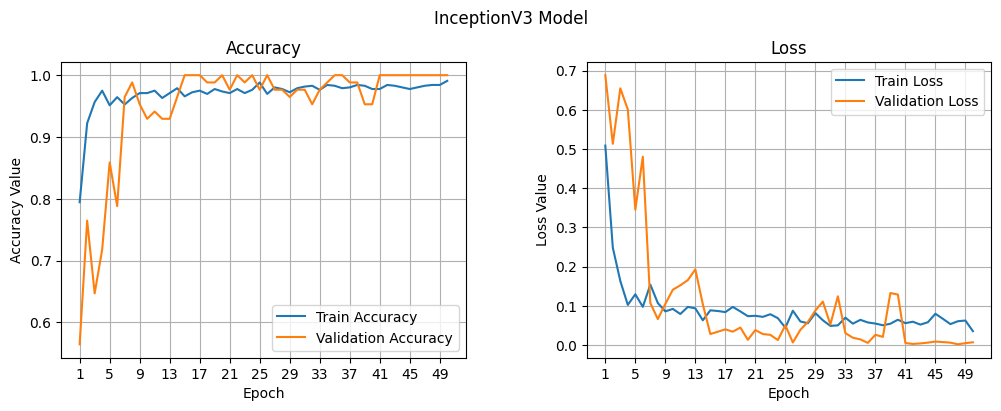

In [21]:
plt.style.use('default')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('InceptionV3 Model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,51))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 51, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 51, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")
plt.savefig('curve1',dpi=400)

In [22]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(Y_test,axis=1)
print(classification_report(y_test_new,pred))

7/7 [==============================] - 3s 299ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      1.00      1.00       110

    accuracy                           1.00       211
   macro avg       1.00      1.00      1.00       211
weighted avg       1.00      1.00      1.00       211



Confusion matrix, without normalization
[[101   0]
 [  0 110]]


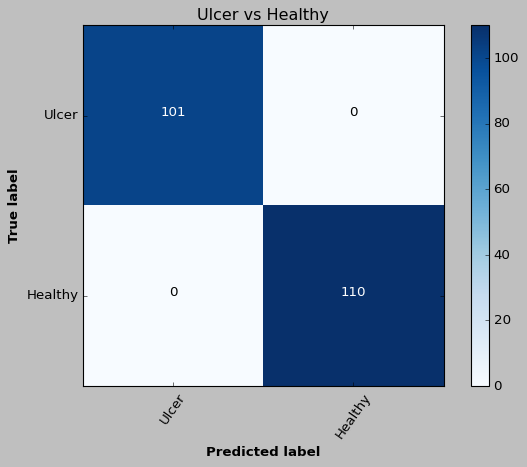

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
plt.style.use('classic')
import itertools
from itertools import product

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, fontweight='bold'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontweight='bold')
    plt.xlabel('Predicted label', fontweight='bold')
    plt.tight_layout()

cm = confusion_matrix(y_test_new,pred)

cm_plot_label =['Ulcer', 'Healthy']
plot_confusion_matrix(cm, cm_plot_label, title ='Ulcer vs Healthy')
plt.savefig('CM',dpi=400)

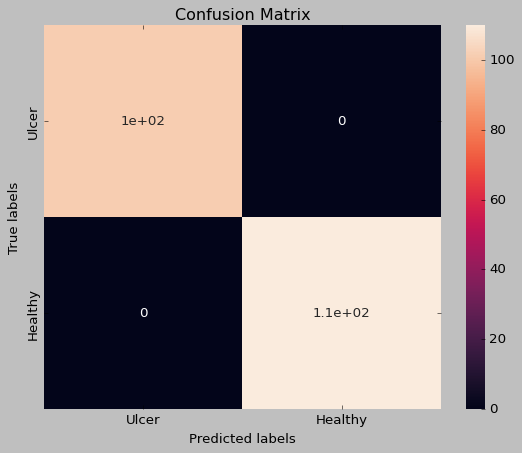

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Ulcer', 'Healthy']); ax.yaxis.set_ticklabels(['Ulcer', 'Healthy'])
plt.savefig('CM_heatmap',dpi=400)

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix, roc_curve, auc,roc_auc_score,matthews_corrcoef,cohen_kappa_score

print('Accuracy: %.3f' % accuracy_score(y_test_new, pred), 'Precision: %.3f' % precision_score(y_test_new, pred),' Recall: %.3f' % recall_score(y_test_new, pred), 
      'F1 Score: %.3f' % f1_score(y_test_new, pred), 'AUC Score: %.3f' % roc_auc_score(y_test_new, pred),'MCC: %.3f' % matthews_corrcoef(y_test_new, pred), 'Kappa: %.3f' % cohen_kappa_score(y_test_new, pred))

Accuracy: 1.000 Precision: 1.000  Recall: 1.000 F1 Score: 1.000 AUC Score: 1.000 MCC: 1.000 Kappa: 1.000


In [27]:
TP=cm[1,1]
TN=cm[0,0]
FP=cm[0,1]
FN=cm[1,0]
print('TP: %f' % TP,'TN: %f' % TN, 'FP: %f' % FP, 'FN: %f' % FN)

TP: 110.000000 TN: 101.000000 FP: 0.000000 FN: 0.000000


In [28]:
specificity=TN/float(TN+FP)
print('Specificity: %.3f' % specificity)
recall=TP/float(TP+FN)
print(' Recall: %.5f' % recall)
precision=TP/float(TP+FP)
print(' Precision: %.5f' % precision)
f1=(2*precision*recall)/(recall+precision)
print('F1 Score: %.5f' % f1)
print( 'AUC Score: %.5f' % roc_auc_score(y_test_new, pred))
from sklearn.metrics import mean_squared_error
print( 'Error Rate: %.5f' % mean_squared_error(y_test_new, pred))
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import cohen_kappa_score

print('MCC: %.5f' % matthews_corrcoef(y_test_new, pred), 'Kappa: %.5f' % cohen_kappa_score(y_test_new, pred))

Specificity: 1.000
 Recall: 1.00000
 Precision: 1.00000
F1 Score: 1.00000
AUC Score: 1.00000
Error Rate: 0.00000
MCC: 1.00000 Kappa: 1.00000


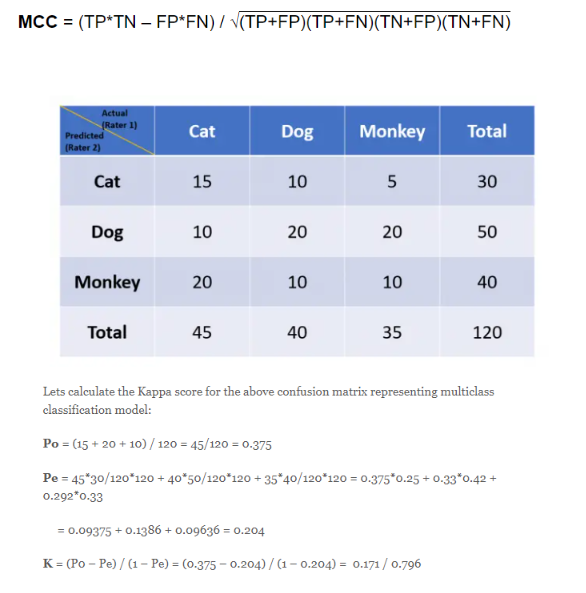

<ipython-input-29-12caf0a51fec>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


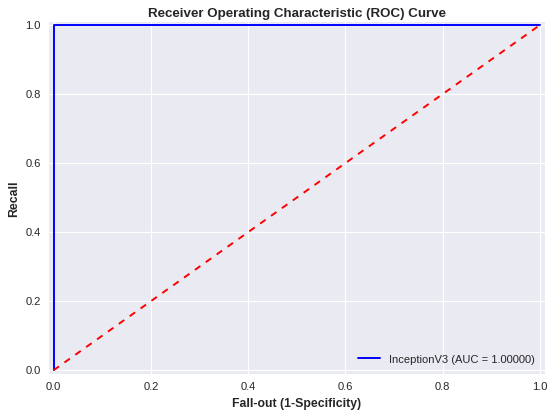

In [29]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
#Print Area Under Curve
false_positive_rate, recall, thresholds = roc_curve(y_test_new, pred)
roc_auc = auc(false_positive_rate, recall)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC) Curve', fontweight='bold')
plt.plot(false_positive_rate, recall, 'b', label = 'InceptionV3 (AUC = %0.5f)' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([-0.01,1.01])
plt.ylim([-0.01,1.01])
plt.ylabel('Recall', fontweight='bold')
plt.xlabel('Fall-out (1-Specificity)', fontweight='bold')
plt.savefig('AUC curve2',dpi=400)
plt.show()

In [30]:
acc = accuracy_score(y_test_new, pred)*100
auc=roc_auc_score(y_test_new, pred)*100
tn, fp, fn, tp = cm.ravel()
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
specificity = tn/(tn+fp)*100
print('Accuracy: {0:0.2f}%'.format(acc))
print('Precision: {0:0.2f}%'.format(precision))
print('Recall or Sensitivity: {0:0.2f}%'.format(recall))
print('Specificity: {0:0.2f}%'.format(specificity))
print('F1-score: {0:0.2f}%'.format(2*precision*recall/(precision+recall)))
print('AUC-score: {0:0.2f}%'.format(auc))
print('Train acc: {0:0.2f}%'.format(np.round((history.history['accuracy'][-1])*100, 2)))

Accuracy: 100.00%
Precision: 100.00%
Recall or Sensitivity: 100.00%
Specificity: 100.00%
F1-score: 100.00%
AUC-score: 100.00%
Train acc: 99.08%


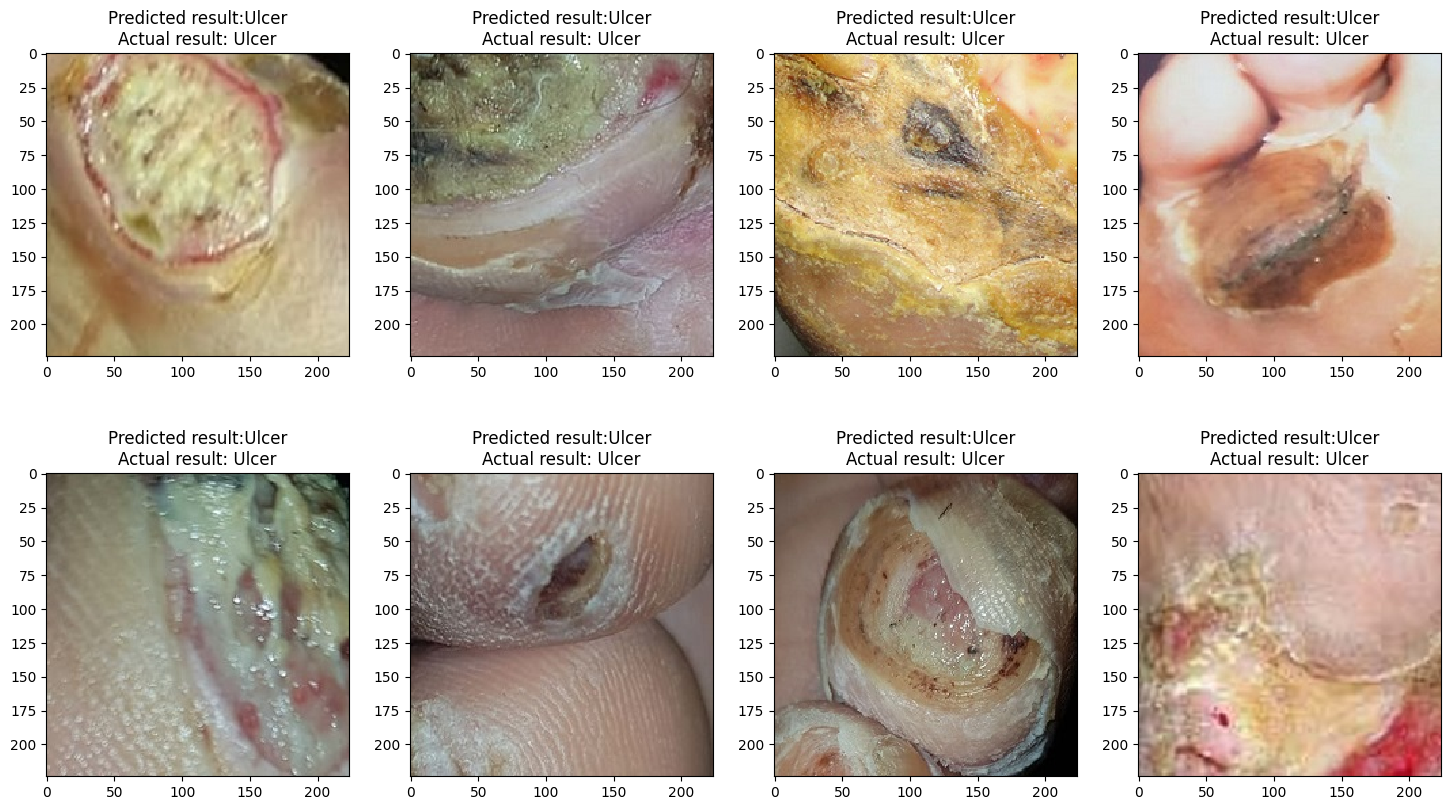

In [32]:
plt.style.use('default')
i=0
prop_class=[]
mis_class=[]
#pred = np.argmax(pred,axis=1)
#y_test_new = np.argmax(Y_test,axis=1)
for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(pred[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(pred[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==1:
        return "Healthy"
    else:
        return "Ulcer"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(pred[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.savefig('prediction',dpi=400)
plt.show()